In [1]:
"""
Import modules
"""

import pathlib
import numpy as np

import SimpleITK as sitk
import matplotlib.pyplot as plt

from platipy.imaging.visualisation.tools import ImageVisualiser
from platipy.imaging.utils.tools import get_com


from platipy.imaging.registration.registration import (
    initial_registration,
    fast_symmetric_forces_demons_registration,
    transform_propagation,
    apply_field
)

%matplotlib notebook

In [ ]:
patient_no="07"
timepoint="2"

ct="WES_007_2_20180814_CT_10_PETCT_WBHDIN_ONC_3.nii.gz"
pet="WES_007_2_20180814_PT_AC_4.nii.gz"
ct_plan="WES_007_3_20181005_CT_15.nii.gz"
breast_struct="WES_007_3_0_RTSTRUCT_WHOLE_BREAST_CTV.nii.gz" #if present

image_ct_0=sitk.ReadImage("/home/alicja/Documents/WES_0" + patient_no + "/IMAGES/"+ct)
image_pt_0_raw=sitk.ReadImage("/home/alicja/Documents/WES_0" + patient_no + "/IMAGES/"+pet)
image_ct_plan = sitk.ReadImage("/home/alicja/Documents/WES_0" + patient_no + "/IMAGES/"+ct_plan)
contour_breast_plan = sitk.ReadImage("/home/alicja/Documents/WES_0" + patient_no + "/STRUCTURES/"+breast_struct)
#L contour_breast_plan = sitk.ReadImage("/home/alicja/Documents/WES_012/STRUCTURES/WES_012_3_0_RTSTRUCT_BREAST_LT_PTV.nii.gz")
#R contour_breast_plan = sitk.ReadImage("/home/alicja/Documents/WES_010/STRUCTURES/WES_010_3_0_RTSTRUCT_BREAST_RT_PTV.nii.gz")

image_pt_0=sitk.Resample(image_pt_0_raw, image_ct_0)

In [ ]:
vis = ImageVisualiser(image_ct_0, cut=[180,220,256], window=[-250, 500])
fig = vis.show()

In [ ]:
vis = ImageVisualiser(image_pt_0, colormap=plt.cm.magma, cut=[180,220,256], window=[0.1, 10000])
fig = vis.show()

In [ ]:
vis = ImageVisualiser(image_ct_plan, axis='z', cut=60, window=[-250, 500], figure_size_in=8)
vis.add_contour({'BREAST' :contour_breast_plan})
fig = vis.show()

In [9]:
#register planning CT to CT
image_ct_plan_to_0_rigid, tfm_plan_to_0_rigid = initial_registration(
    image_ct_0,
    image_ct_plan,
    options={
        'shrink_factors': [8,4],
        'smooth_sigmas': [0,0],
        'sampling_rate': 0.5,
        'final_interp': 2,
        'metric': 'mean_squares',
        'optimiser': 'gradient_descent_line_search',
        'number_of_iterations': 25},
    reg_method='Rigid')

<IPython.core.display.Javascript object>


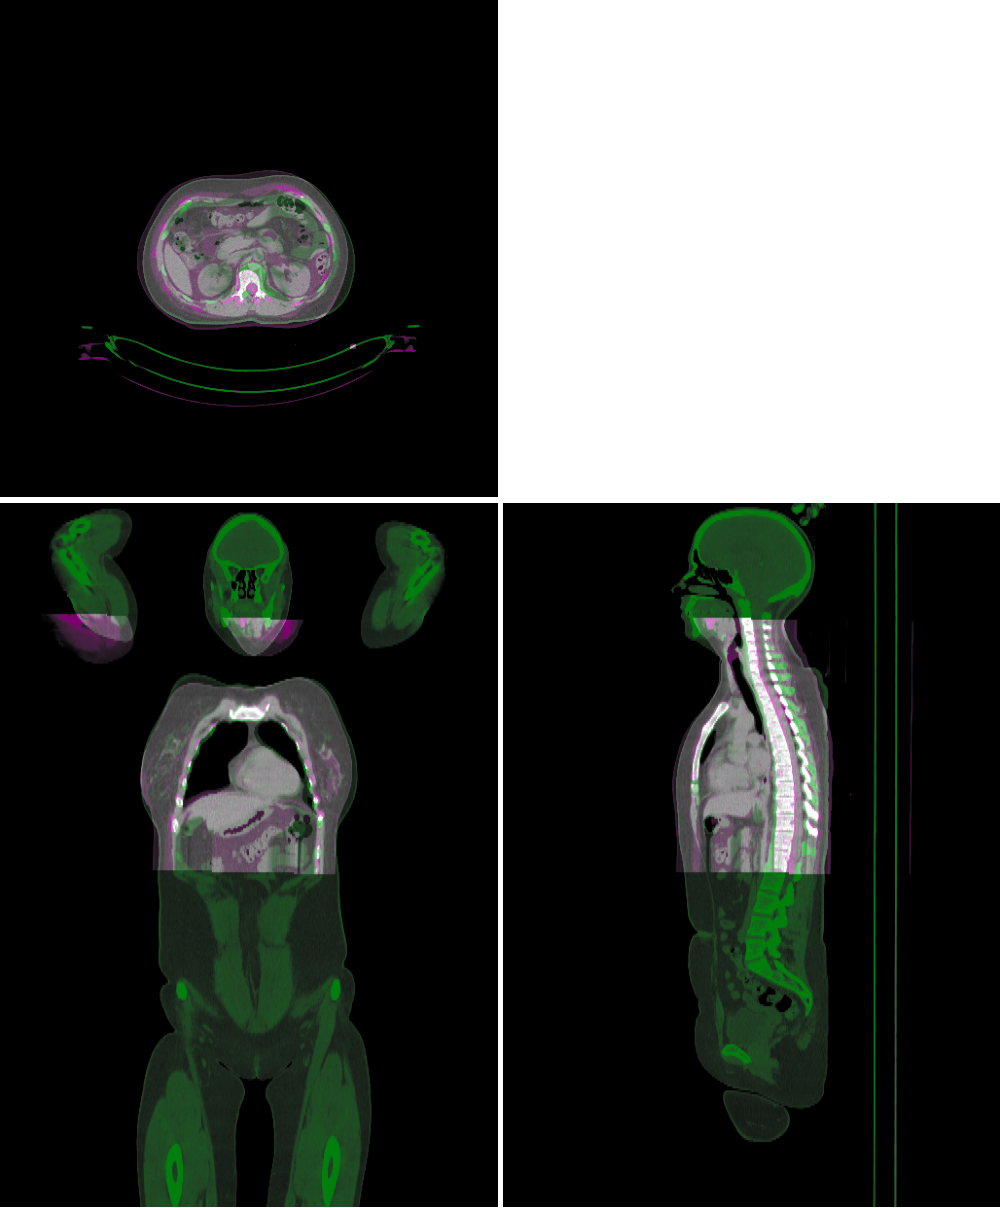

In [10]:
vis = ImageVisualiser(image_ct_0, cut=[180,220,256], window=[-250, 500])
vis.add_comparison_overlay(image_ct_plan_to_0_rigid)
fig = vis.show()

In [11]:
image_ct_plan_to_0_dir, tfm_plan_to_0_dir = fast_symmetric_forces_demons_registration(
    image_ct_0,
    image_ct_plan_to_0_rigid,
    resolution_staging=[4,2],
    iteration_staging=[10,10]
)

<IPython.core.display.Javascript object>


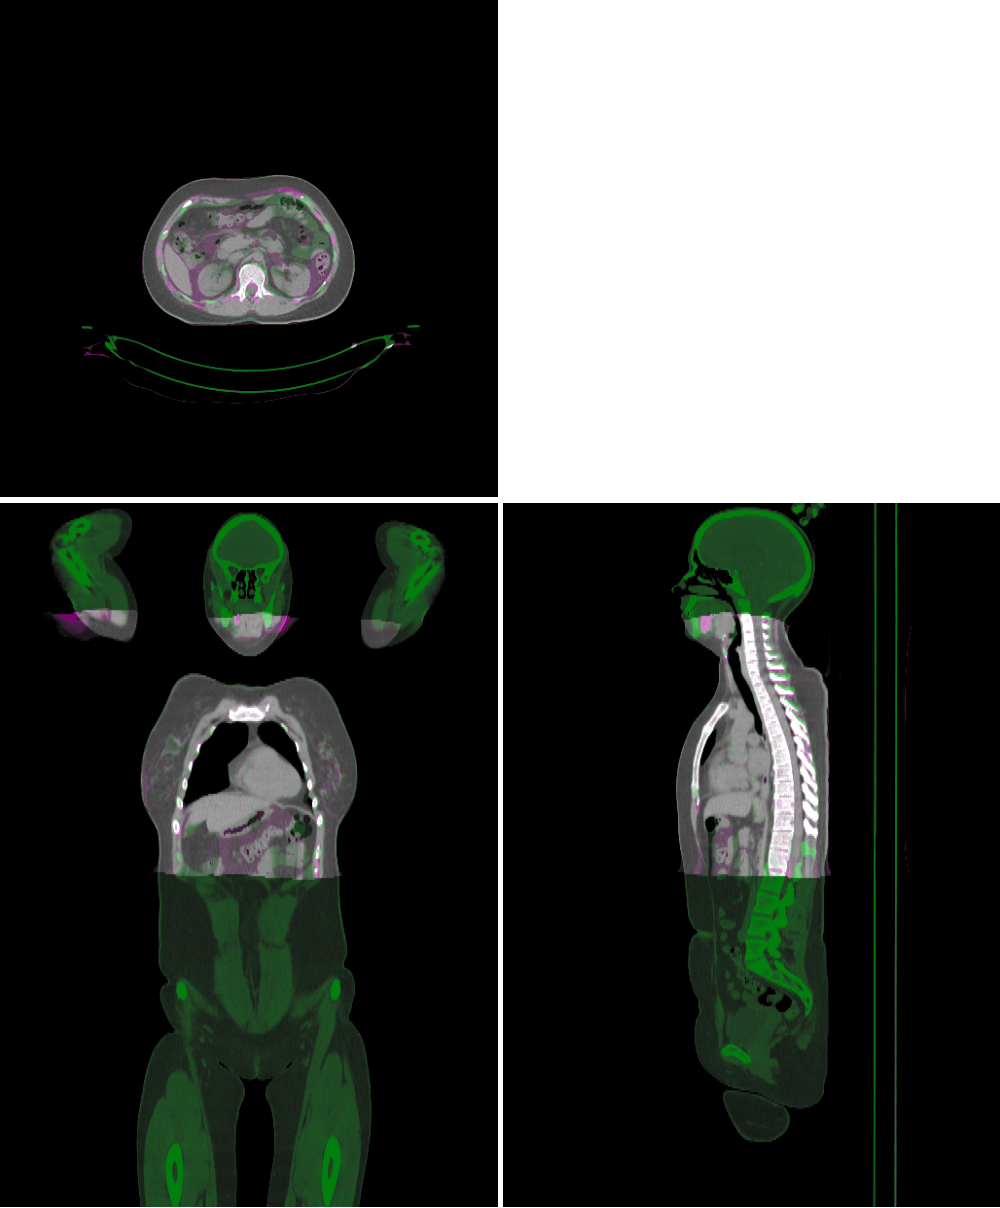

In [12]:
vis = ImageVisualiser(image_ct_0, cut=[180,220,256], window=[-250, 500])
vis.add_comparison_overlay(image_ct_plan_to_0_dir)
fig = vis.show()

In [13]:
#register breast structure to CT
contour_breast_plan_to_0_rigid = transform_propagation(
    image_ct_0,
    contour_breast_plan,
    tfm_plan_to_0_rigid,
    structure=True
)

contour_breast_plan_to_0_dir = apply_field(
    contour_breast_plan_to_0_rigid,
    tfm_plan_to_0_dir,
    structure=True
)

In [14]:
contour_breast_plan_to_0_dir_arr=sitk.GetArrayFromImage(contour_breast_plan_to_0_dir)
#contour_breast_plan_to_0_dir_arr[:,:,220:]=0
#contour_breast_plan_to_0_dir_arr[:163,:,:]=0
#contour_breast_plan_to_0_dir_arr[186:,:,:]=0
contour_breast_plan_to_0_dir2=sitk.GetImageFromArray(contour_breast_plan_to_0_dir_arr)
contour_breast_plan_to_0_dir2.CopyInformation(contour_breast_plan_to_0_dir)
contour_breast_plan_to_0_dir=contour_breast_plan_to_0_dir2

In [15]:
breast_contour_dilate=sitk.BinaryDilate(contour_breast_plan_to_0_dir, (2,2,2)) #if using different structure

In [16]:
sitk.WriteImage(breast_contour_dilate,"breast_contour_dilate_"+patient_no+"_"+timepoint+".nii.gz")

<IPython.core.display.Javascript object>


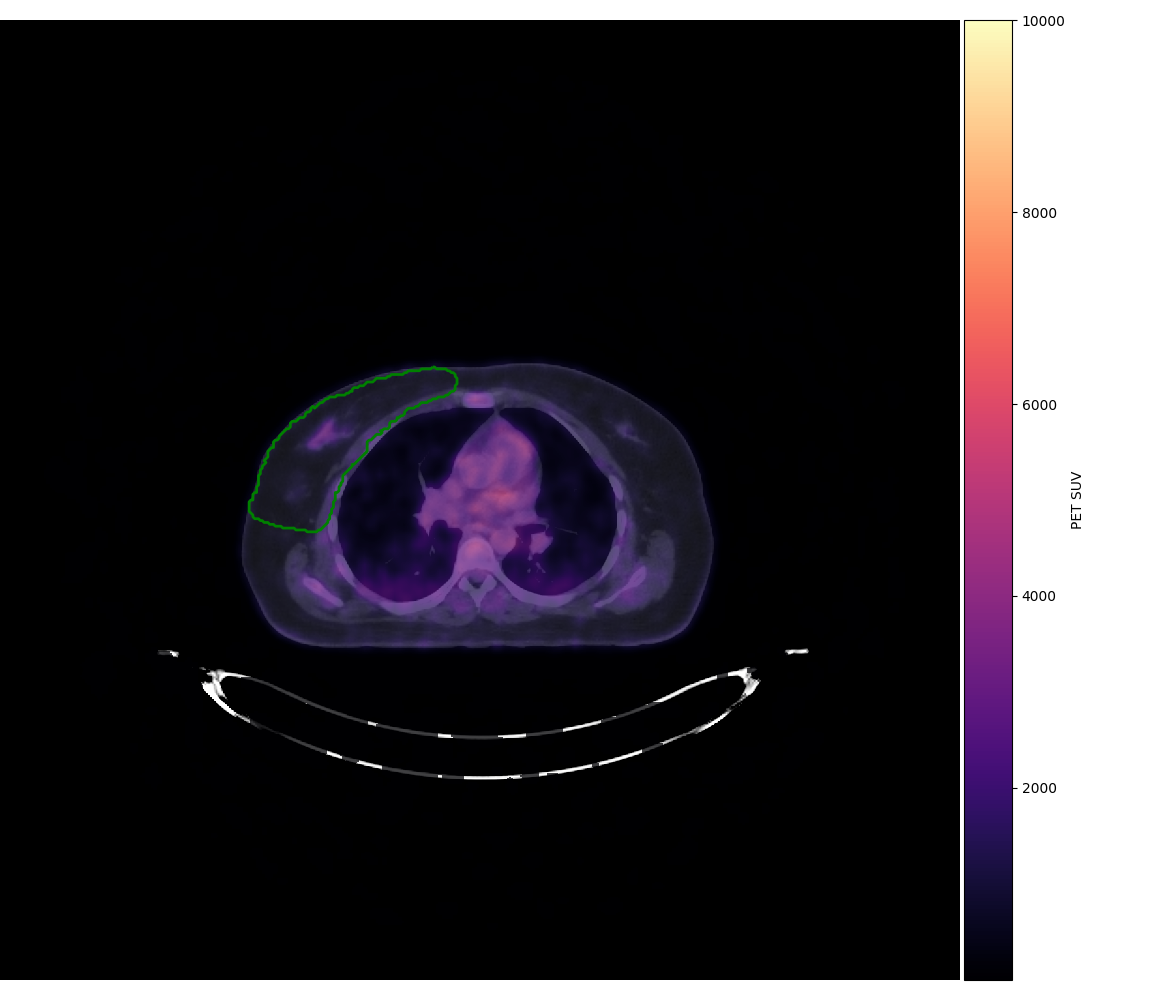

No contour levels were found within the data range.
The following kwargs were not used by contour: 'label'


In [17]:
vis = ImageVisualiser(image_ct_0, axis='z', cut=240, window=[-250, 500])
vis.add_scalar_overlay(image_pt_0, name='PET SUV', colormap=plt.cm.magma, min_value=0.1, max_value=10000)
vis.add_contour(contour_breast_plan_to_0_dir, name='R BREAST', color='g') #or breast_contour_dilate
fig = vis.show()

In [18]:
#use structure information for breast to mask out all but the breast area (create new array with everything but
#this area set to 0)
masked_pet_breast = sitk.Mask(image_pt_0, contour_breast_plan_to_0_dir) #or breast_contour_dilate

<IPython.core.display.Javascript object>


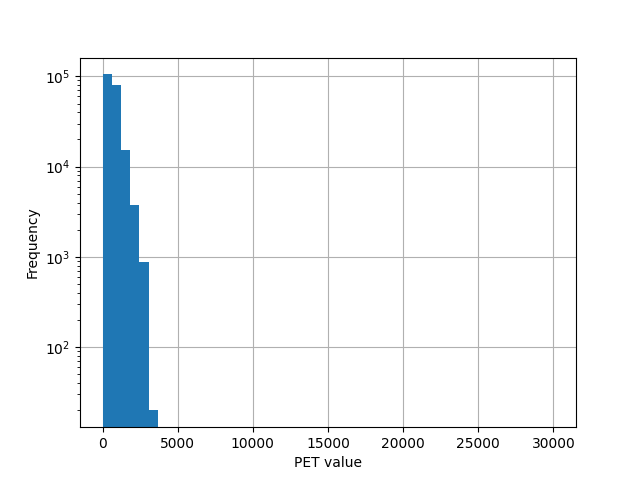

In [19]:
values = sitk.GetArrayViewFromImage(masked_pet_breast).flatten()

fig, ax = plt.subplots(1,1)
ax.hist(values, bins=np.linspace(1,30000,50), histtype='stepfilled', lw=2)
ax.set_yscale('log')
ax.grid()
ax.set_axisbelow(True)
ax.set_xlabel('PET value')
ax.set_ylabel('Frequency')
fig.show()

In [20]:
sitk.WriteImage(masked_pet_breast, "masked_pet_breast_WES_0" + patient_no + "_" + timepoint + ".nii.gz")

In [21]:
#get 95th percentile, then mask the breast volume
masked_pet_breast=sitk.Resample(masked_pet_breast, image_pt_0_raw)
mask_arr=sitk.GetArrayFromImage(masked_pet_breast)
mask_arr=mask_arr.flatten() 

p = np.percentile(mask_arr[mask_arr>0], 95)
print(p)

tum = sitk.Mask(image_pt_0_raw, masked_pet_breast>p)

1409.871918479946


In [22]:
sitk.WriteImage(tum, "pet_seg_0"+patient_no+"_"+timepoint+"_95pc.nii.gz")

In [23]:
p = np.percentile(mask_arr[mask_arr>0], 90)
print(p)

tum = sitk.Mask(image_pt_0_raw, masked_pet_breast>p)

sitk.WriteImage(tum, "pet_seg_0"+patient_no+"_"+timepoint+"_90pc.nii.gz")

1140.7813731667854


In [24]:
p = np.percentile(mask_arr[mask_arr>0], 97)
print(p)

tum = sitk.Mask(image_pt_0_raw, masked_pet_breast>p)

sitk.WriteImage(tum, "pet_seg_0"+patient_no+"_"+timepoint+"_97pc.nii.gz")

1636.6364287897006


In [25]:
tum=sitk.Cast(tum,sitk.sitkInt16)
new_tums = sitk.RelabelComponent(sitk.ConnectedComponent(tum))
new_tum = (new_tums==1)
sitk.WriteImage(new_tum, "pet_seg_0"+patient_no+"_"+timepoint+"_97pc.nii.gz")